# 07. Function Prediction using PICRUSt2

Author: Minghang Li

In this Jupyter Notebook, we perform function inference using the `picrust2`
plugin based on amplicon-based sequencing results.

<div style="background-color: lightsalmon; padding: 10px;">
    
**NOTE**: `q2-picrust2` plugin is not directly compatible with `qiime2-2024.10` as of now. We need to manually install the plugin from source and modify `setup.py` to make it compatible with the current version of `qiime2`.
</div>



**Notebook overview**<br>
[1. Setup](#1-setup)<br>
[2. Run `picrust2` full pipeline](#2-run-picrust2-full-pipeline)<br>
[3. Analysis and Visualization](#3-downstream-analysis-and-visualization)<br>
[4. Thoughts and discussion](#4-thoughts-and-discussion)<br>

## 1. Setup

In [1]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path
from scipy.cluster.hierarchy import fcluster, cut_tree

%matplotlib inline

In [2]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [3]:
import sys
sys.path.append(root.as_posix())

from utils.plot import *

In [4]:
# personal preferences:

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Run `picrust2` full pipeline

PICRUSt2 (Phylogenetic Investigation of Communities by Reconstruction of Unobserved States) is a software for predicting functional abundances based only on marker gene (here, it's 16S rRNA) sequences.

"Function" here refers to gene families such as KEGG orthologs (KO), Enzyme Classification (EC) numbers, and metabolic (MetaCyc) pathways.

Here we use **maximum parsimony** (`mp`) for hidden state predcition (HSP) and **SEPP** (SATé-Enabled Phylogenetic Placement) method for tree placement (cannot use `EPA-NG` due to limited RAM + trying to be consistent with `q2-feature-insertion`). `--p-edge-exponent` was set to be `0` for the pipeline to run successfully (as SEPP handles branch weighing internally)

<div style="background-color: aliceblue; padding: 10px;">

**NOTE** `qiime picrust2 custom-tree-pipeline` can only use trees built from `qiime fragment-insertion sepp` as an input. So the tree built in `03_phylogeny.ipynb` cannot be used.
</div>

In [ ]:
! qiime picrust2 full-pipeline \
    --i-table $data_dir/table-filtered.qza \
    --i-seq $data_dir/rep-seqs-filtered.qza \
    --p-threads 16 \
    --p-hsp-method mp \
    --p-edge-exponent 0 \
    --p-placement-tool sepp \
    --output-dir $data_dir/q2-picrust2_fullpipeline \
    --verbose

## 3. Downstream Analysis and Visualization


In [35]:
# define picrust results directory for easy access
picrust_res = data_dir / "q2-picrust2_fullpipeline"

### 3.1 Summarize the table

Summarize the information using `feature-table summarize`

In [4]:
! qiime feature-table summarize \
   --i-table $picrust_res/ko_metagenome.qza \
   --o-visualization $picrust_res/ko_metagenome.qzv

! qiime feature-table summarize \
   --i-table $picrust_res/ec_metagenome.qza \
   --o-visualization $picrust_res/ec_metagenome.qzv

! qiime feature-table summarize \
   --i-table $picrust_res/pathway_abundance.qza \
   --o-visualization $picrust_res/pathway_abundance.qzv

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/ko_metagenome.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/ec_metagenome.qzv
Saved Visualization to: /home/matchy233/study/alien/data/processed/q2-picrust2_fullpipeline/pathway_abundance.qzv


In [5]:
Visualization.load(picrust_res / "ko_metagenome.qzv")

<visualization: Visualization uuid: 9cd5edf0-56a5-43aa-94c9-2b3c028fe41c>

In [29]:
Visualization.load(picrust_res / "ec_metagenome.qzv")

<visualization: Visualization uuid: d5c7f04f-a737-4c53-948b-653d760ee61c>

In [30]:
Visualization.load(picrust_res / "pathway_abundance.qzv")

<visualization: Visualization uuid: 5a8f31d6-c765-4501-8ec5-f786e609da69>

### 3.2 Perform alpha rarefaction to determine the depth of sequencing

(Not performed here as the rarefaction took a long time to run)

#### 3.2.1 KEGG

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/ko_metagenome.qza \
    --p-max-depth 30000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-ko.qzv

#### 3.2.2 EC counts

In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/ec_metagenome.qza \
    --p-max-depth 30000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-ec.qzv

#### 3.2.3 MetaCyc pathways


In [ ]:
! qiime diversity alpha-rarefaction \
    --i-table $picrust_res/pathway_abundance.qza \
    --p-max-depth 30000 \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/alpha-rarefaction-pathabund.qzv

#### 3.2.4 Determine the depth of sequencing

Our goal is to determine the depth of sequencing that captures the most
 diversity in the samples. The sampling depth is selected to be the lowest depth
(so that we lose the fewest samples) that captures **at least 80%** diversity in
the samples whereas the rarefaction curve plateaus.

##### KEGG

In [ ]:
! qiime tools export \
    --input-path $data_dir/alpha-rarefaction-ko.qzv \
    --output-path $data_dir/alpha-rarefaction-ko

In [11]:
ko_selected_depth = 10000

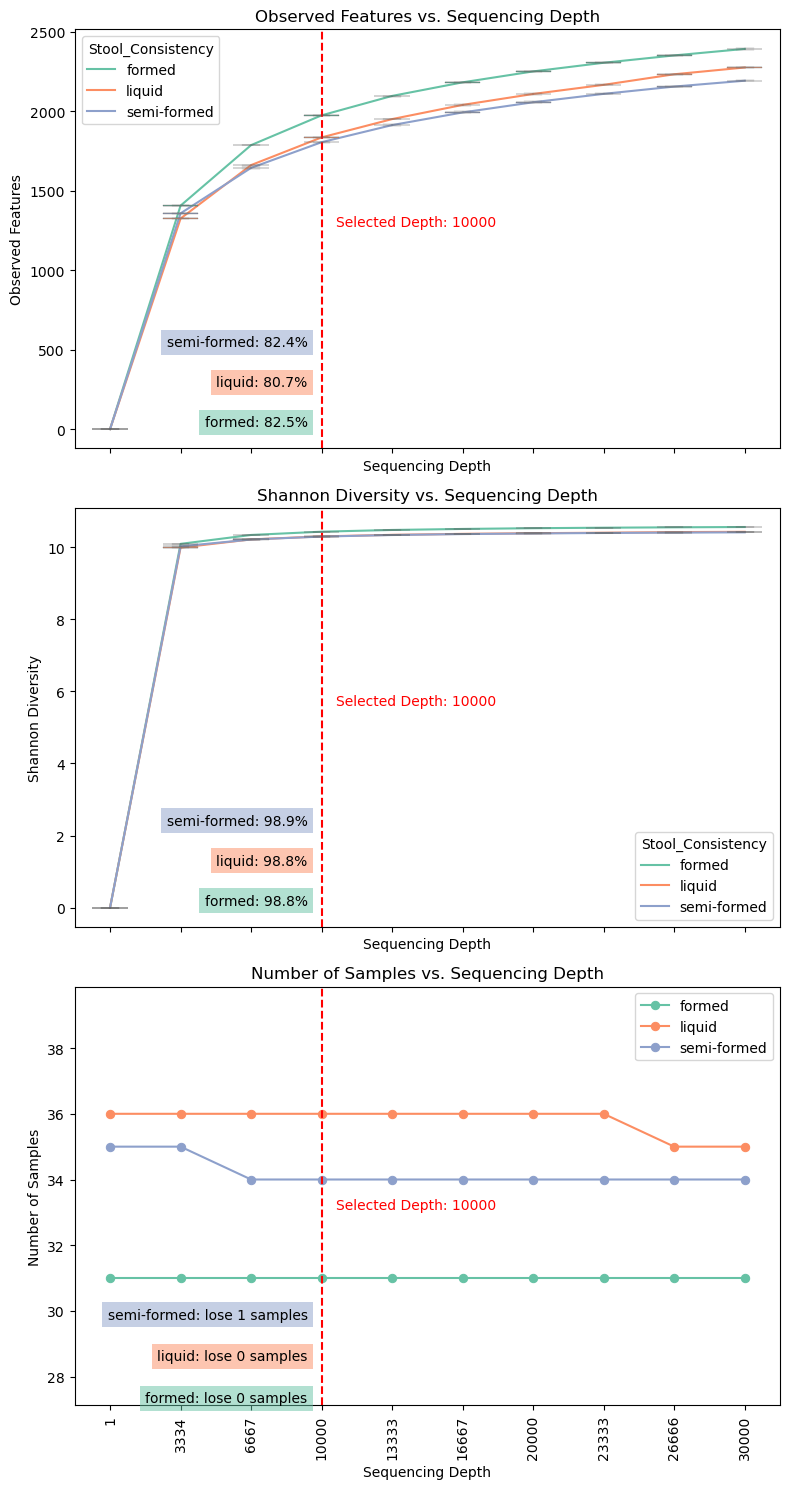

In [12]:
plot_rarefaction_curves(
    data_dir / "alpha-rarefaction-ko",
    "Stool_Consistency",
    ko_selected_depth,
    figsize=(5, 12),
    output_file=vis_dir / "alpha-rarefaction-KO-Stool_Consistency.png",
)

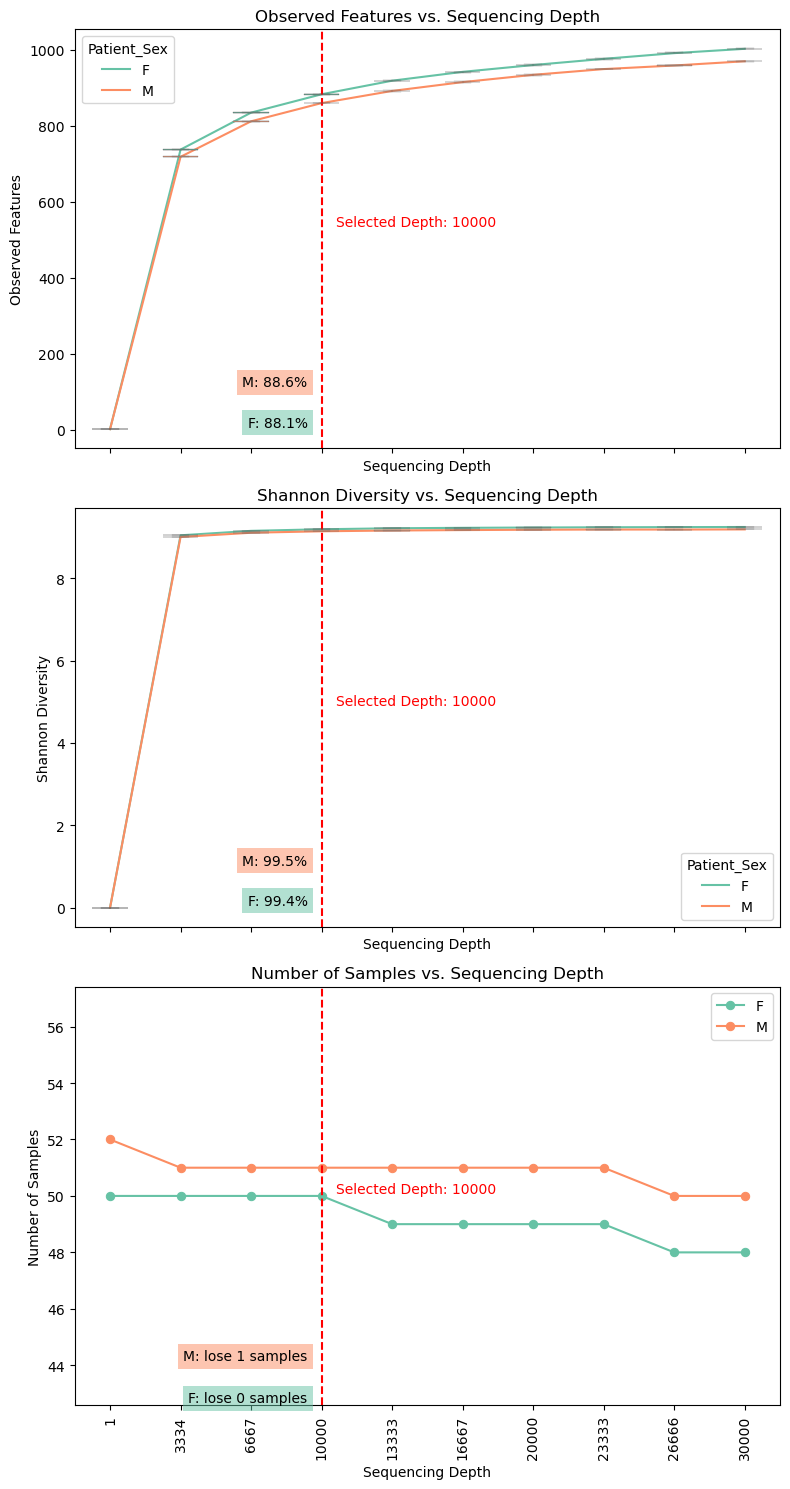

In [14]:
plot_rarefaction_curves(
    data_dir / "alpha-rarefaction-ec",
    "Patient_Sex",
    ko_selected_depth,
    figsize=(5, 12),
    output_file=vis_dir / "alpha-rarefaction-KO-Patient_Sex.png",
)

##### EC

In [12]:
! qiime tools export \
    --input-path $data_dir/alpha-rarefaction-ec.qzv \
    --output-path $data_dir/alpha-rarefaction-ec

Exported /home/matchy233/study/alien/data/processed/alpha-rarefaction-ec.qzv as Visualization to directory /home/matchy233/study/alien/data/processed/alpha-rarefaction-ec


In [18]:
ec_selected_depth = 10000


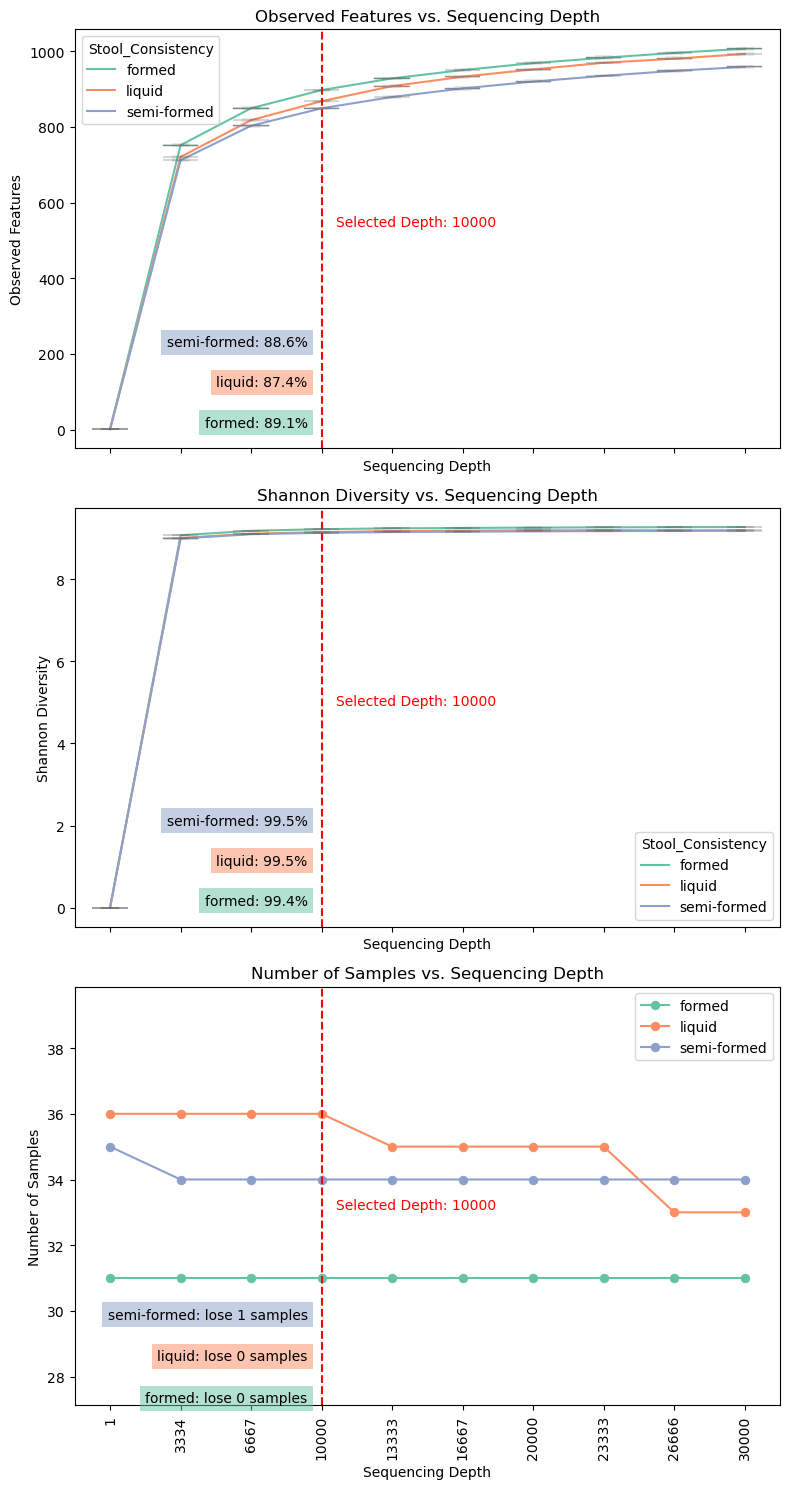

In [19]:
plot_rarefaction_curves(
    data_dir / "alpha-rarefaction-ec",
    "Stool_Consistency",
    ec_selected_depth,
    figsize=(5, 12),
    output_file=vis_dir / "alpha-rarefaction-ec-Stool_Consistency.png",
)

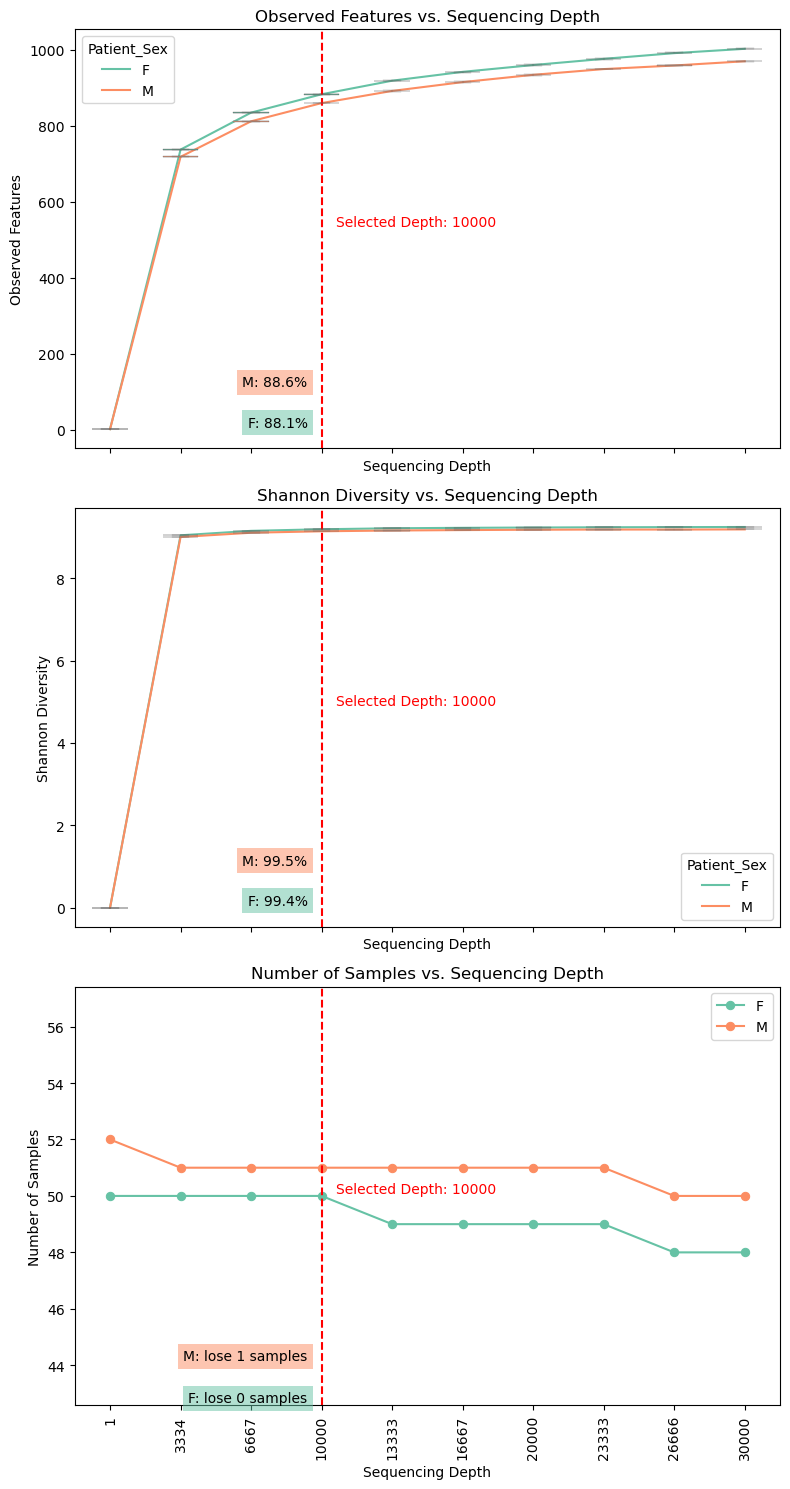

In [20]:
plot_rarefaction_curves(
    data_dir / "alpha-rarefaction-ec",
    "Patient_Sex",
    ec_selected_depth,
    output_file=vis_dir / "alpha-rarefaction-ec-Patient_Sex.png",
)

##### MetaCyc

In [24]:
! qiime tools export \
    --input-path $data_dir/alpha-rarefaction-pathabun.qzv \
    --output-path $data_dir/alpha-rarefaction-pathabun

Exported /home/matchy233/study/alien/data/processed/alpha-rarefaction-pathabun.qzv as Visualization to directory /home/matchy233/study/alien/data/processed/alpha-rarefaction-pathabun


In [31]:
metacyc_selected_depth = 6667

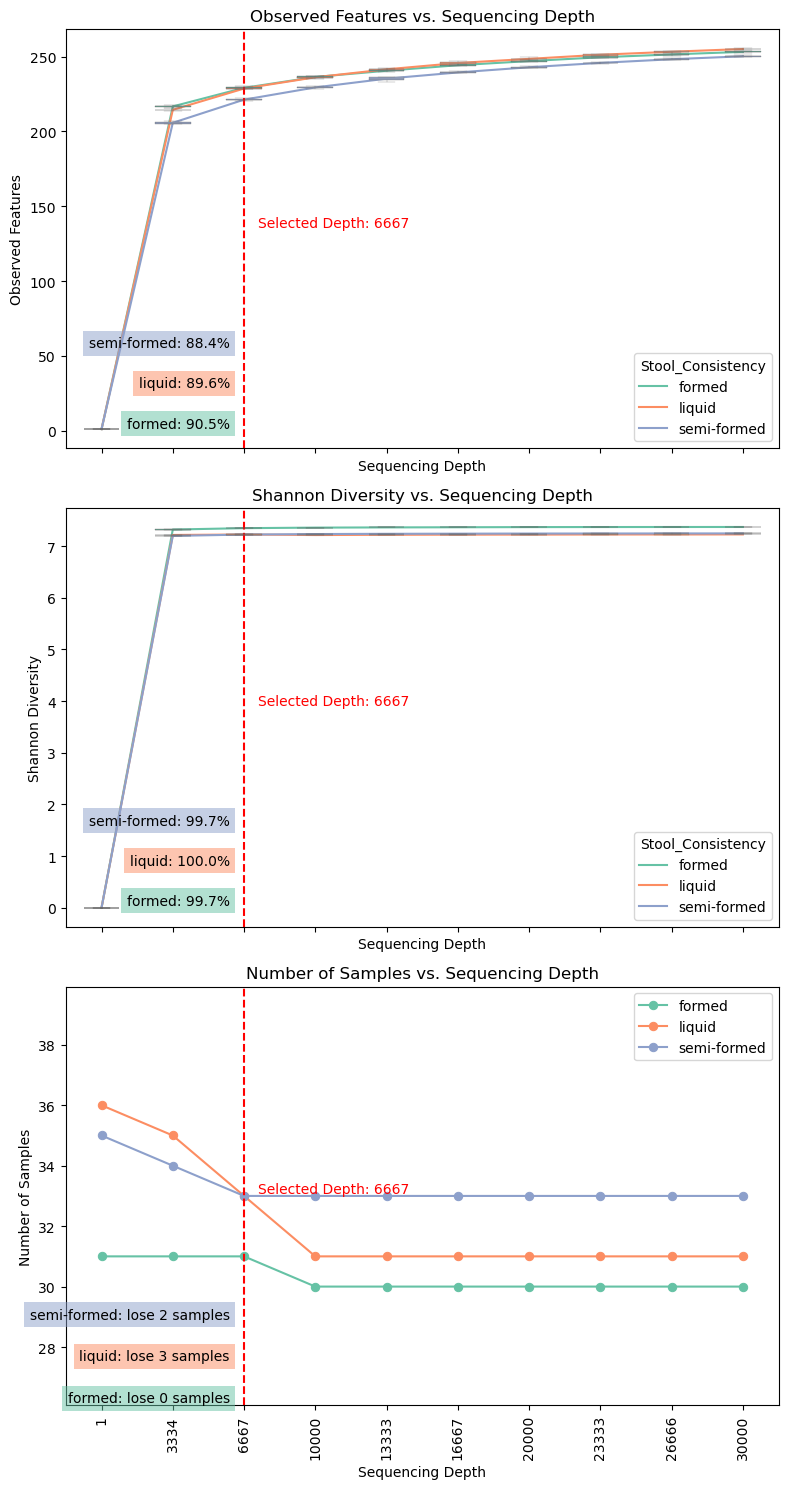

In [32]:
plot_rarefaction_curves(
    data_dir / "alpha-rarefaction-pathabun",
    "Stool_Consistency",
    metacyc_selected_depth,
    figsize=(5, 12),
    output_file=vis_dir / "alpha-rarefaction-pathabun-Stool_Consistency.png",
)

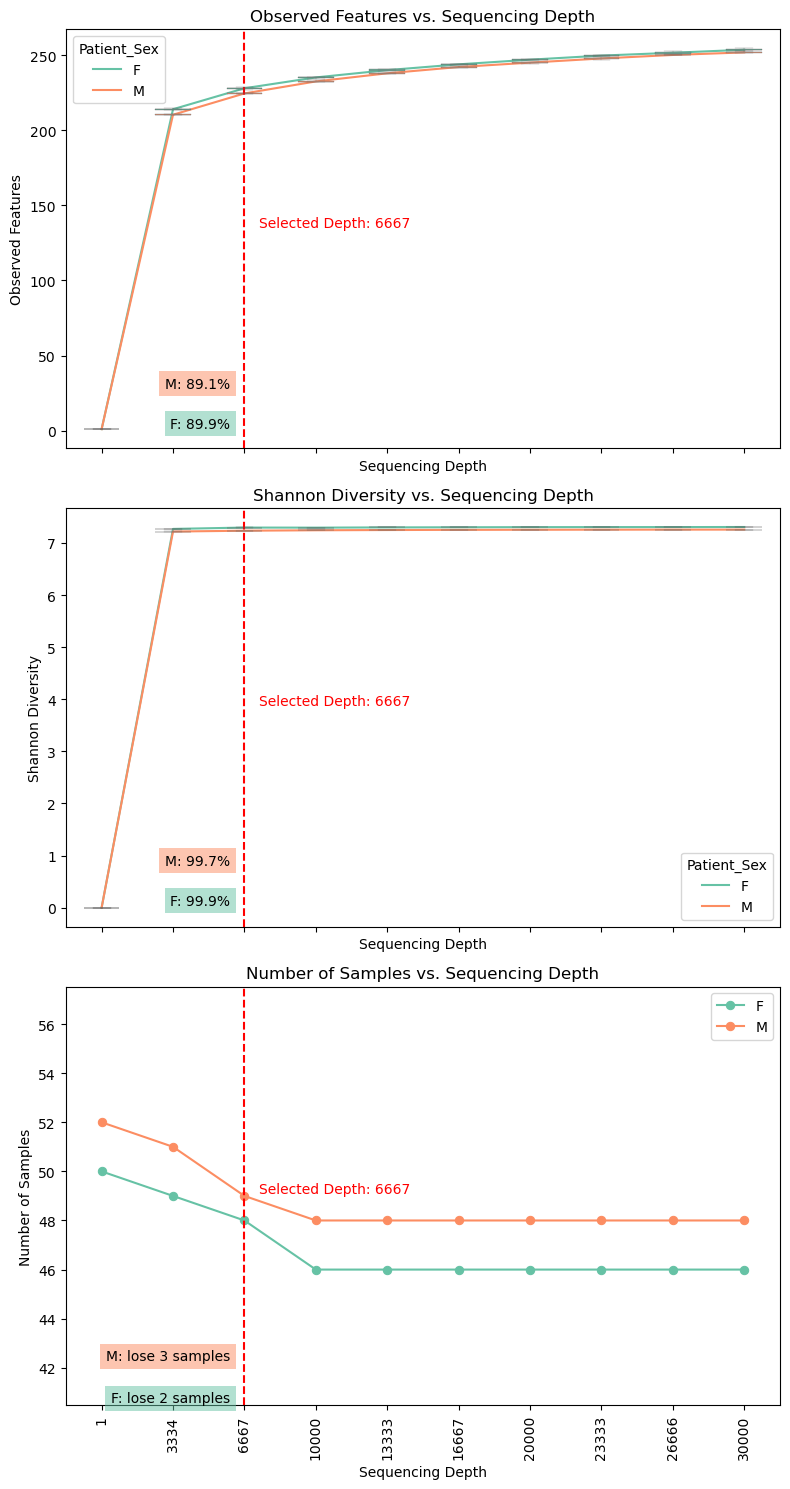

In [33]:
plot_rarefaction_curves(
    data_dir / "alpha-rarefaction-pathabun",
    "Patient_Sex",
    metacyc_selected_depth,
    output_file=vis_dir / "alpha-rarefaction-pathabun-Patient_Sex.png",
)

### 3.3 Compute diversity metrics

After determining the sampling depth, we can compute the diversity metrics.

#### 3.3.1 KEGG

In [31]:
! if [ -d $data_dir/ko_metagenome_core_metrics ]; then rm -r $data_dir/ko_metagenome_core_metrics; fi
! qiime diversity core-metrics \
   --i-table $picrust_res/ko_metagenome.qza \
   --p-sampling-depth $ko_selected_depth \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/ko_metagenome_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: /home/matchy233/study/alien/data/processed/ko_metagenome_core_metrics/bray_curtis_pcoa_results.qza


#### 3.3.2 EC counts

In [17]:
! if [ -d $data_dir/ec_metagenome_core_metrics ]; then rm -r $data_dir/ec_metagenome_core_metrics; fi
! qiime diversity core-metrics \
   --i-table $picrust_res/ec_metagenome.qza \
   --p-sampling-depth $ec_selected_depth \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/ec_metagenome_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: ec_metagenome_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: ec_metagenome_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: ec_metagenome_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: ec_metagenome_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: ec_metagenome_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: ec_metagenome_core_metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: ec_metagenome_core_metrics/jaccard_emperor.qzv
Saved Visualization to: ec_metagenome_core_metrics/bray_curtis_emperor.qzv


#### 3.3.3 Path abundance

In [18]:
! if [ -d $data_dir/pathway_abundance_core_metrics ]; then rm -r $data_dir/pathway_abundance_core_metrics; fi
! qiime diversity core-metrics \
   --i-table $picrust_res/pathway_abundance.qza \
   --p-sampling-depth $metacyc_selected_depth \
   --m-metadata-file $data_dir/metadata.tsv \
   --output-dir $data_dir/pathway_abundance_core_metrics \
   --parallel \
   --p-n-jobs 16

Saved FeatureTable[Frequency] to: pathway_abundance_core_metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: pathway_abundance_core_metrics/evenness_vector.qza
Saved DistanceMatrix to: pathway_abundance_core_metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: pathway_abundance_core_metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: pathway_abundance_core_metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: pathway_abundance_core_metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: pathway_abundance_core_metrics/jaccard_emperor.qzv
Saved Visualization to: pathway_abundance_core_metrics/bray_curtis_emperor.qzv


#### 3.3.4. Load the functional profiles for visualization and initial exploration

In [36]:
ko = q2.Artifact.load(picrust_res / "ko_metagenome.qza").view(pd.DataFrame)
ko.head()

K00001  K00002     K00003    K00004     K00005    K00007     K00008  \
EG0024  29595.76     0.0  164935.50    546.25   27661.88     92.69  473551.33   
EG0031   3060.39     0.0    1539.26  70880.50  132233.35  74481.19     601.16   
EG0039  49784.60     0.0   50511.19   1872.42   17796.00      0.00   56987.94   
EG0055  12084.15     0.0  182254.98   2813.66    5853.22     48.00    1348.67   
EG0057  60850.38     0.0   49605.96  19489.00   31896.67      0.00   12205.59   

           K00009     K00010     K00012  ...  K19744     K19745  K19746  \
EG0024    4580.44  229425.13  160271.21  ...     0.0     142.69     0.0   
EG0031  129770.24  277973.09  128340.65  ...    10.0  128234.94    10.0   
EG0039    4624.45    1956.20   22965.92  ...     0.0    2886.92     0.0   
EG0055  175788.25  350586.32     417.83  ...     0.0      91.50     0.0   
EG0057   11283.30     589.71     425.59  ...     0.0      21.00     0.0   

          K19775     K19776   K19777   K19778  K19780    K19784     K19789  
EG0024     56.69     134.69     0.00     0.00     0.0     85.58     142.69  
EG0031  57555.94  114543.94     4.75     4.75     0.0  55974.44  128234.94  
EG0039   2884.25    2884.25  2884.25  2884.25     0.0  44585.44    2884.25  
EG0055     43.50      91.50     6.50     6.50     0.0    403.57      91.50  
EG0057     21.00      21.00     0.00     0.00     0.0    103.96      21.00  

[5 rows x 6401 columns]

In [37]:
ec = q2.Artifact.load(picrust_res / "ec_metagenome.qza").view(pd.DataFrame)
ec.head()

EC:1.1.1.1  EC:1.1.1.100  EC:1.1.1.103  EC:1.1.1.108  EC:1.1.1.11  \
EG0024   236290.26     211757.34      28034.02          0.00        92.69   
EG0031   390627.67     415254.40     128251.14        213.20     74481.19   
EG0039   155419.10     211850.99       5925.75        265.50         0.00   
EG0055   202488.22     717906.15        136.75       2744.25        48.00   
EG0057   160530.27     165589.35         67.33       8415.00         0.00   

        EC:1.1.1.122  EC:1.1.1.125  EC:1.1.1.130  EC:1.1.1.132  EC:1.1.1.133  \
EG0024          0.00     120724.52        807.83          0.00     110040.76   
EG0031         22.40     202201.77      86751.08         16.20      87347.59   
EG0039         23.67       7951.33       4092.25          7.17      28481.69   
EG0055          2.50     175313.00         61.50          1.25     177685.98   
EG0057         51.00        316.00          7.00         14.00       6812.38   

        ...  EC:6.4.1.4  EC:6.4.1.5  EC:6.5.1.1  EC:6.5.1.2  EC:6.5.1.3  \
EG0024  ...        0.00         0.0     2144.00   153940.11      471.84   
EG0031  ...       26.20        20.0       44.80   258820.31    13716.45   
EG0039  ...       11.17         0.0     3795.02    90131.94     3309.42   
EG0055  ...        1.25         0.0        5.00   182723.73       17.00   
EG0057  ...       29.00         0.0       89.00    78609.63       36.75   

        EC:6.5.1.4  EC:6.5.1.6  EC:6.5.1.7  EC:6.6.1.1  EC:6.6.1.2  
EG0024        0.00        0.00        0.00      768.00      643.73  
EG0031        4.75       16.20       16.20       31.60       21.87  
EG0039     2884.25      162.17      162.17      343.84      168.17  
EG0055        6.50        1.25        1.25       41.74       40.08  
EG0057        0.00       29.00       29.00       29.00       21.67  

[5 rows x 1994 columns]

In [38]:
pathabun = q2.Artifact.load(f"{picrust_res}/pathway_abundance.qza").view(pd.DataFrame)
pathabun.head()

1CMET2-PWY  3-HYDROXYPHENYLACETATE-DEGRADATION-PWY  \
EG0024  116613.984453                               73.424692   
EG0031  136253.349598                            63725.681123   
EG0039   77411.718837                                0.000000   
EG0055  181117.459408                               43.401534   
EG0057   53230.419360                               32.435472   

        AEROBACTINSYN-PWY  ALL-CHORISMATE-PWY  ANAEROFRUCAT-PWY  \
EG0024          63.643626         1026.966436      27815.373858   
EG0031       64514.001632       148867.177540     167925.553339   
EG0039          39.073526         5988.831451      84702.114029   
EG0055          49.754902          433.312325     233345.335016   
EG0057          25.315068          133.563270      83460.634850   

        ANAGLYCOLYSIS-PWY  ARG+POLYAMINE-SYN     ARGDEG-PWY  ARGORNPROST-PWY  \
EG0024      151411.464318        2608.113398     252.180004      4558.641993   
EG0031      169866.365287      144954.170796  141759.514298     87195.474330   
EG0039      103051.671420       14120.130585    4853.163308      5341.081270   
EG0055      214956.294156         432.364351     143.700771      5556.457529   
EG0057       90371.770969         119.174362      41.711924     50651.344895   

           ARGSYN-PWY  ...     THISYN-PWY  THREOCAT-PWY    THRESYN-PWY  \
EG0024  107229.507915  ...   94380.275853    259.752512  110387.739891   
EG0031  161750.564324  ...  120603.131866    204.378689  163193.943180   
EG0039   33180.001699  ...   16654.384958   5807.628900   43766.580400   
EG0055   14290.748880  ...     340.750434    192.351322  218178.886473   
EG0057   20611.037128  ...     458.877527     72.135985   57783.902711   

        TRNA-CHARGING-PWY     TRPSYN-PWY  TYRFUMCAT-PWY     UBISYN-PWY  \
EG0024      110445.977771  105577.623217       0.000000     339.050562   
EG0031      142500.286816  156707.938691      26.996907  145507.073631   
EG0039       77373.310502   33170.646036      14.660025    3782.890741   
EG0055        8956.587539   22821.853759       2.059130     143.420182   
EG0057        3151.556643   22091.600950      29.857820      40.349876   

        UDPNAGSYN-PWY  VALDEG-PWY     VALSYN-PWY  
EG0024   34476.365984         0.0  162192.010400  
EG0031  130545.837853         0.0  163119.763567  
EG0039   78984.024230         0.0   55215.280267  
EG0055  182571.575573         0.0   12403.531249  
EG0057   78450.424058         0.0   31334.792862  

[5 rows x 372 columns]

### 3.4 Visualize the results

We visualize the metagnome predictions using heatmaps, with x-axis as samples 
and y-axis as the corresponding KEGG orthologs / EC numbers / MetaCyc pathways. 
The color intensity represents the abundance of the gene family in the sample 
(log-transformed), with redder color indicating higher abundance.

#### 3.3.1 KEGG orthologs heatmap and clustermap

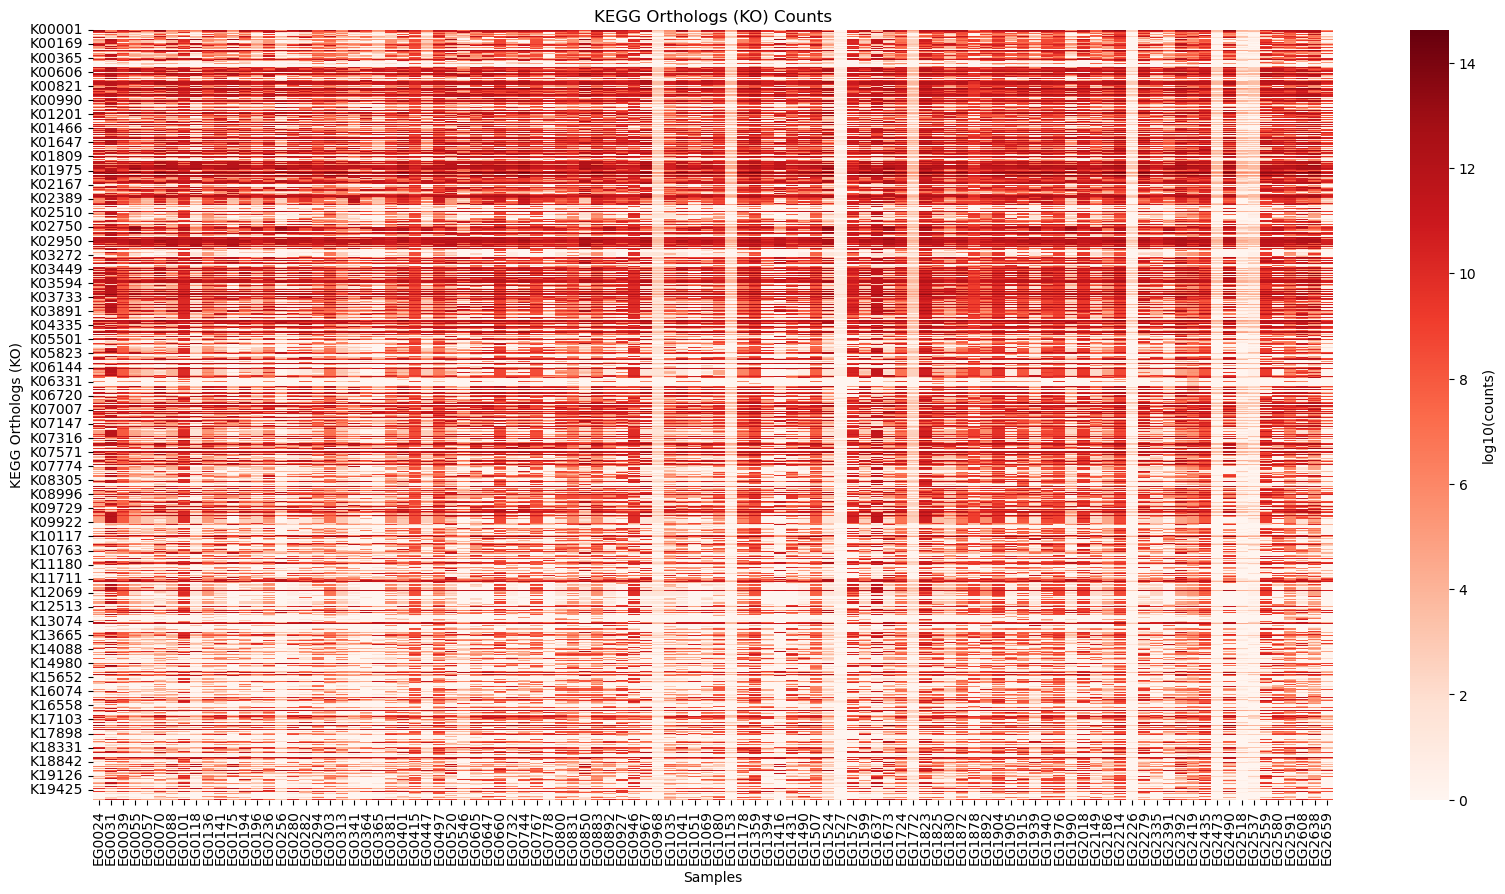

In [40]:
# Visualize KEGG orthologs - heatmap
ko_log = np.log(ko + 1)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.heatmap(ko_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, ax=ax, xticklabels=ko_log.index)
g.set_title("KEGG Orthologs (KO) Counts")
g.set_xlabel("Samples")
g.set_ylabel("KEGG Orthologs (KO)")
g.figure.savefig(vis_dir / "ko_heatmap.png")

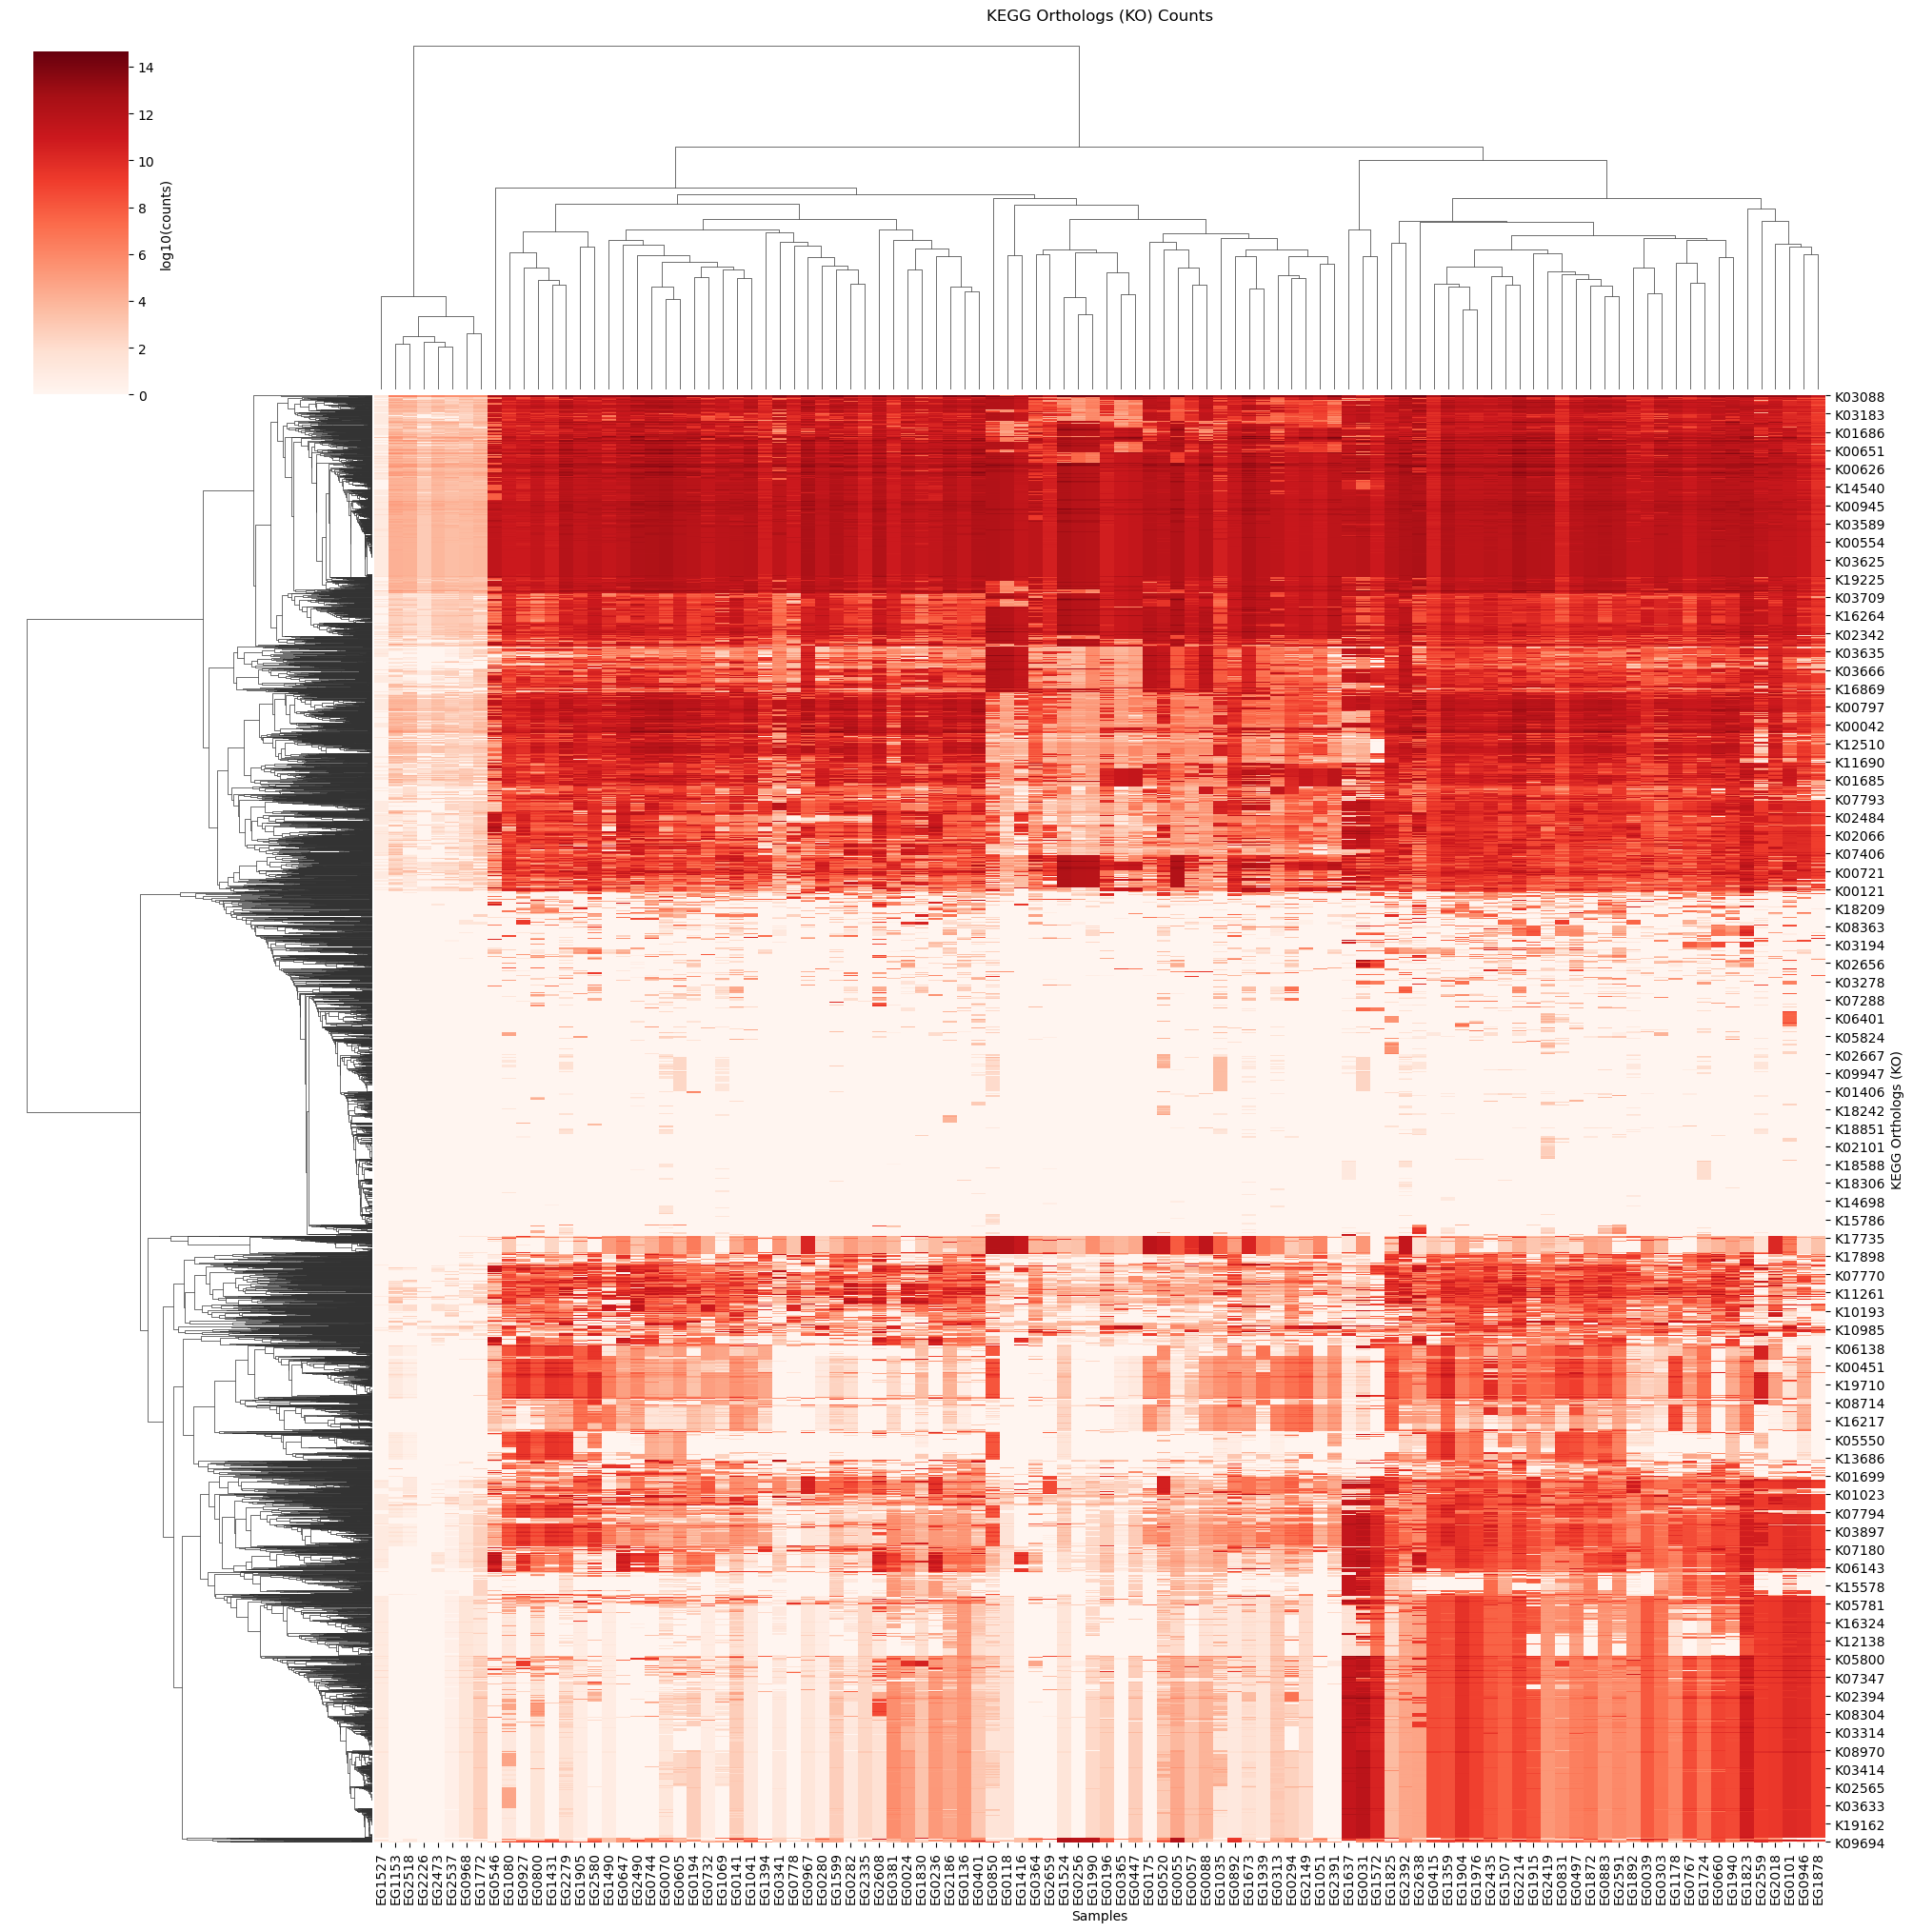

In [54]:
ko_cm = sns.clustermap(ko_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, figsize=(20, 20), xticklabels=ko_log.index)
ko_cm.ax_col_dendrogram.set_title("KEGG Orthologs (KO) Counts")
ko_cm.ax_heatmap.set_xlabel("Samples")
ko_cm.ax_heatmap.set_ylabel("KEGG Orthologs (KO)")
ko_cm.savefig(vis_dir / "ko_clustermap.png")

#### 3.3.2 EC numbers heatmap and clustermap

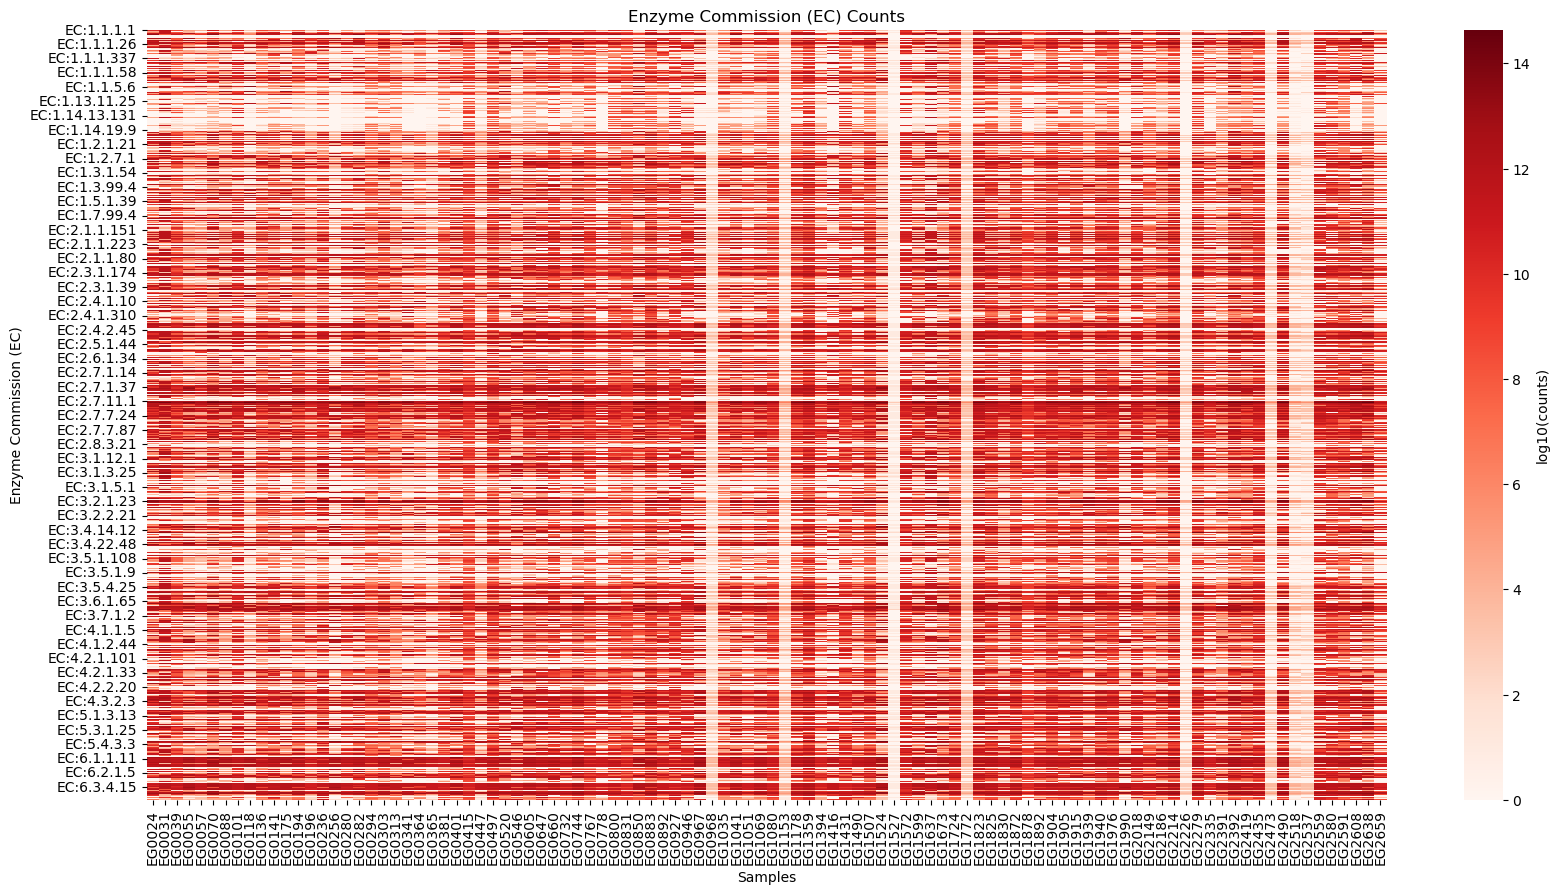

In [39]:
ec_log = np.log(ec + 1)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.heatmap(ec_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, ax=ax, xticklabels=ec_log.index)
g.set_title("Enzyme Commission (EC) Counts")
g.set_xlabel("Samples")
g.set_ylabel("Enzyme Commission (EC)")
g.figure.savefig(vis_dir / "ec_heatmap.png")


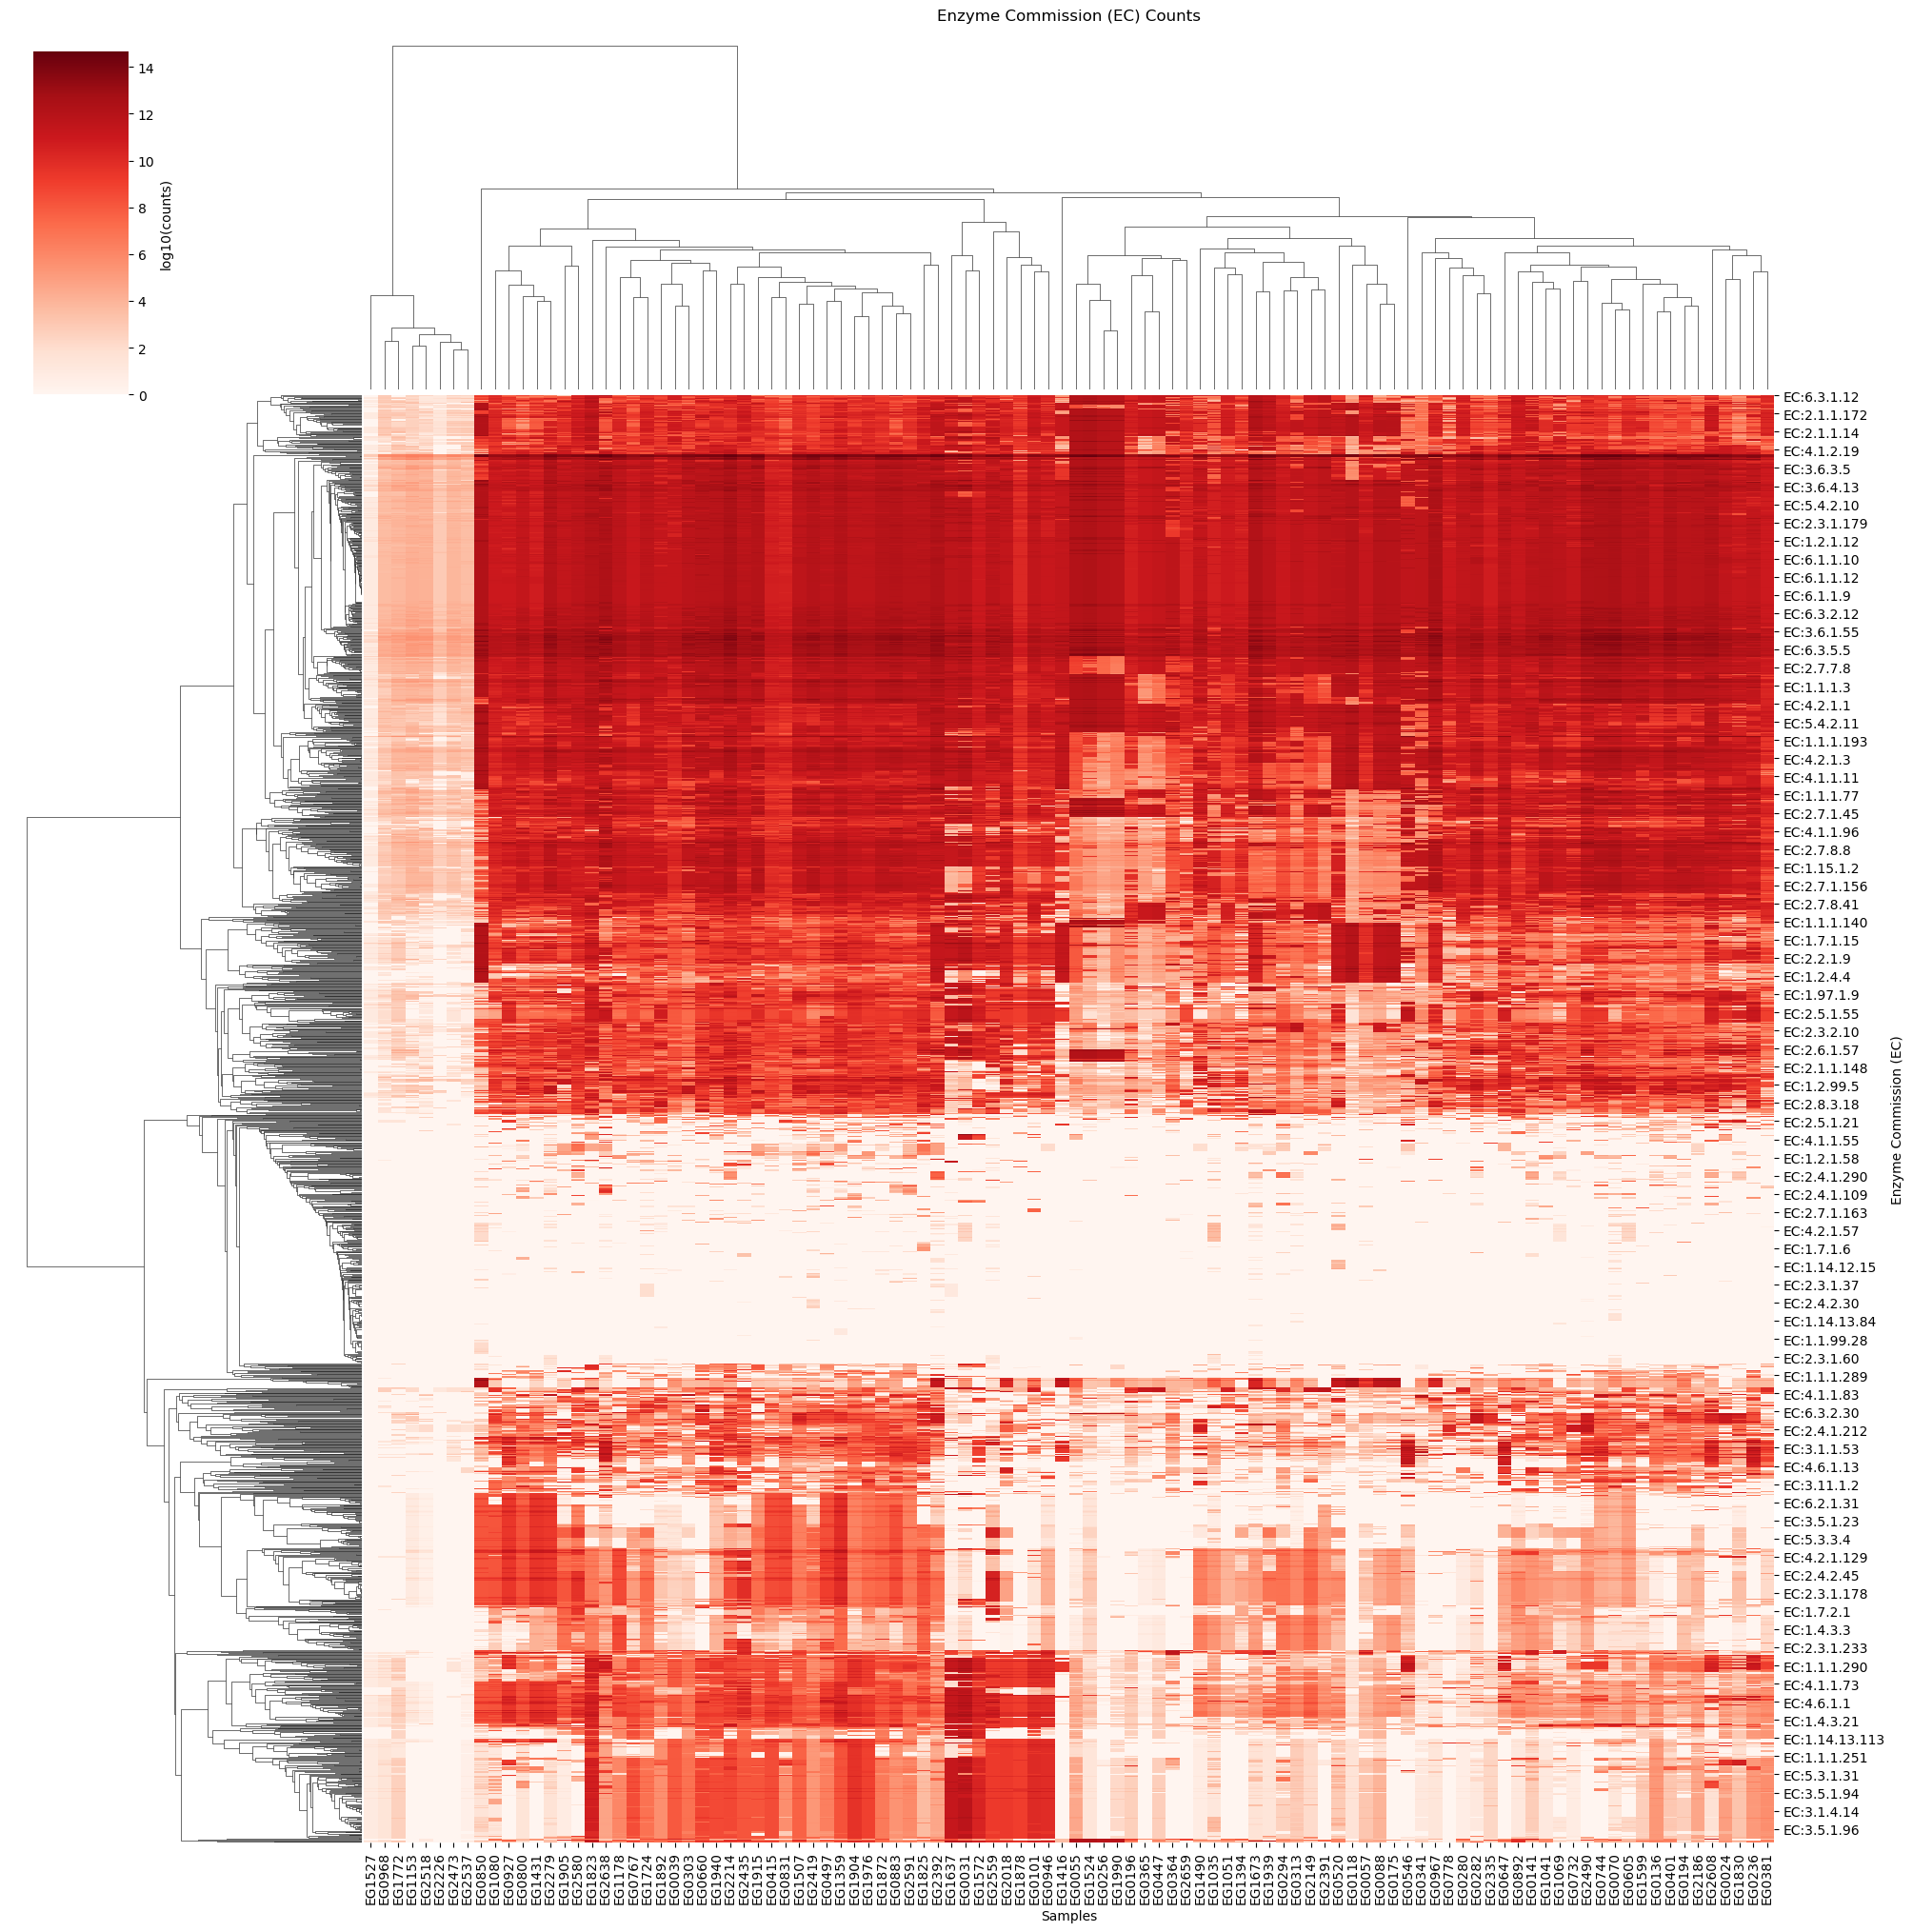

In [48]:
ec_cm = sns.clustermap(ec_log.T, cmap="Reds", cbar_kws={'label': 'log10(counts)'}, figsize=(20, 20), xticklabels=ec_log.index)
ec_cm.ax_col_dendrogram.set_title("Enzyme Commission (EC) Counts")
ec_cm.ax_heatmap.set_xlabel("Samples")
ec_cm.ax_heatmap.set_ylabel("Enzyme Commission (EC)")
ec_cm.savefig(vis_dir / "ec_clustermap.png")


#### 3.3.3 MetaCyc pathways heatmap and clustermap

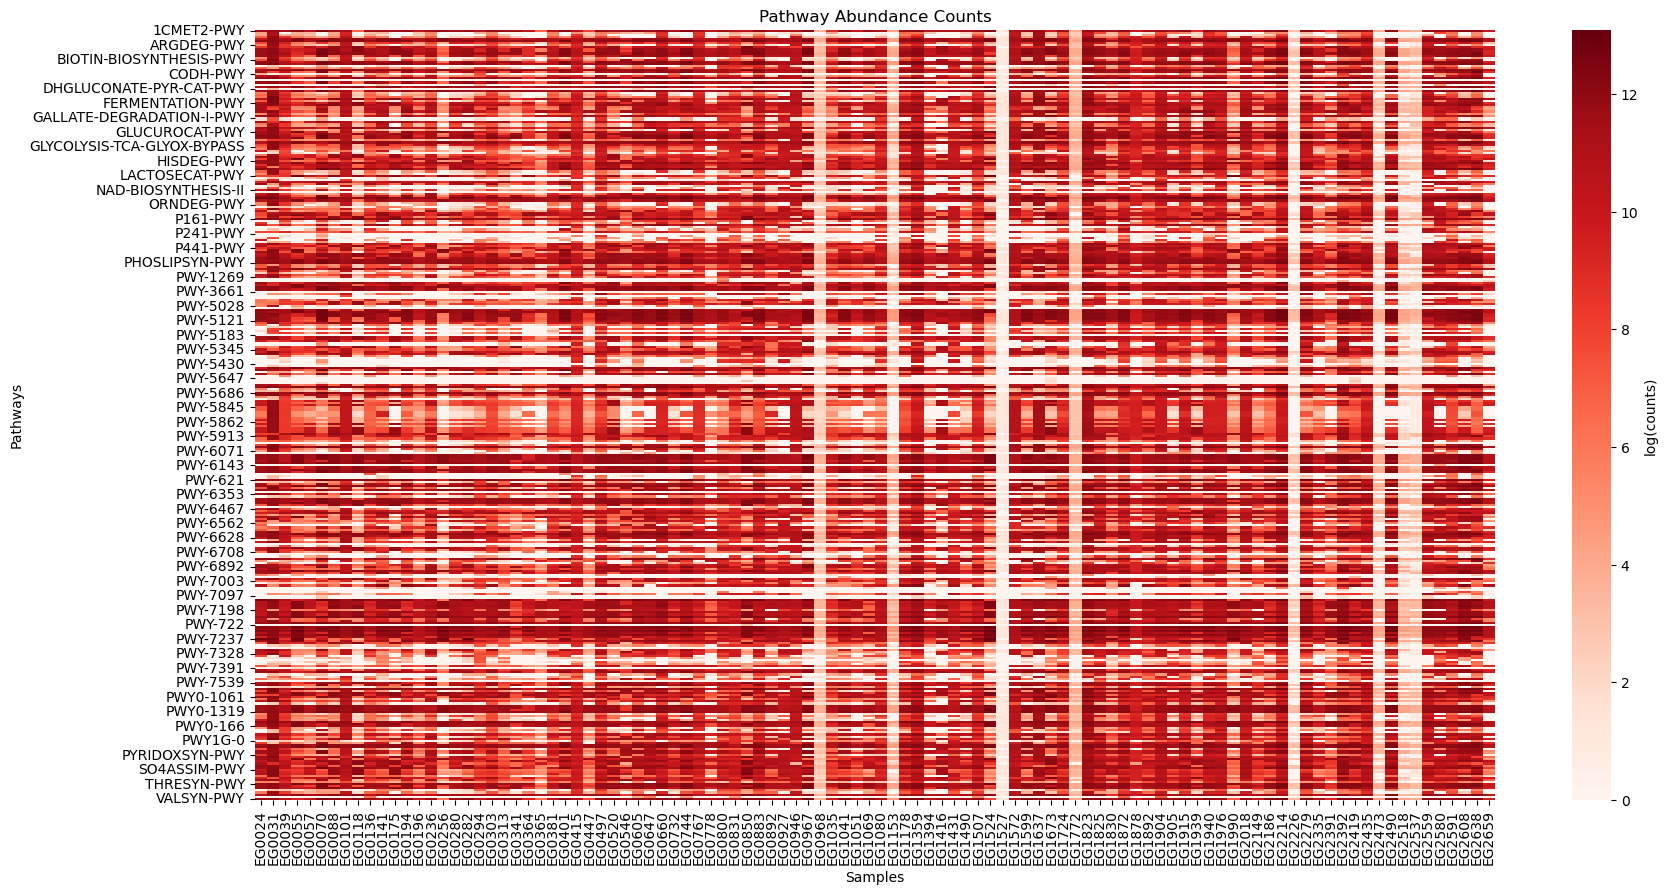

In [50]:
# visualize the data using a heatmap
pathabun_log = np.log(pathabun + 1)

fig, ax = plt.subplots(figsize=(20, 10))
g = sns.heatmap(pathabun_log.T, cmap="Reds", cbar_kws={'label': 'log(counts)'}, xticklabels=pathabun_log.index, ax=ax)
g.set_title("Pathway Abundance Counts")
g.set_xlabel("Samples")
g.set_ylabel("Pathways")
g.figure.savefig(vis_dir / "pathway_abundance_heatmap.png")


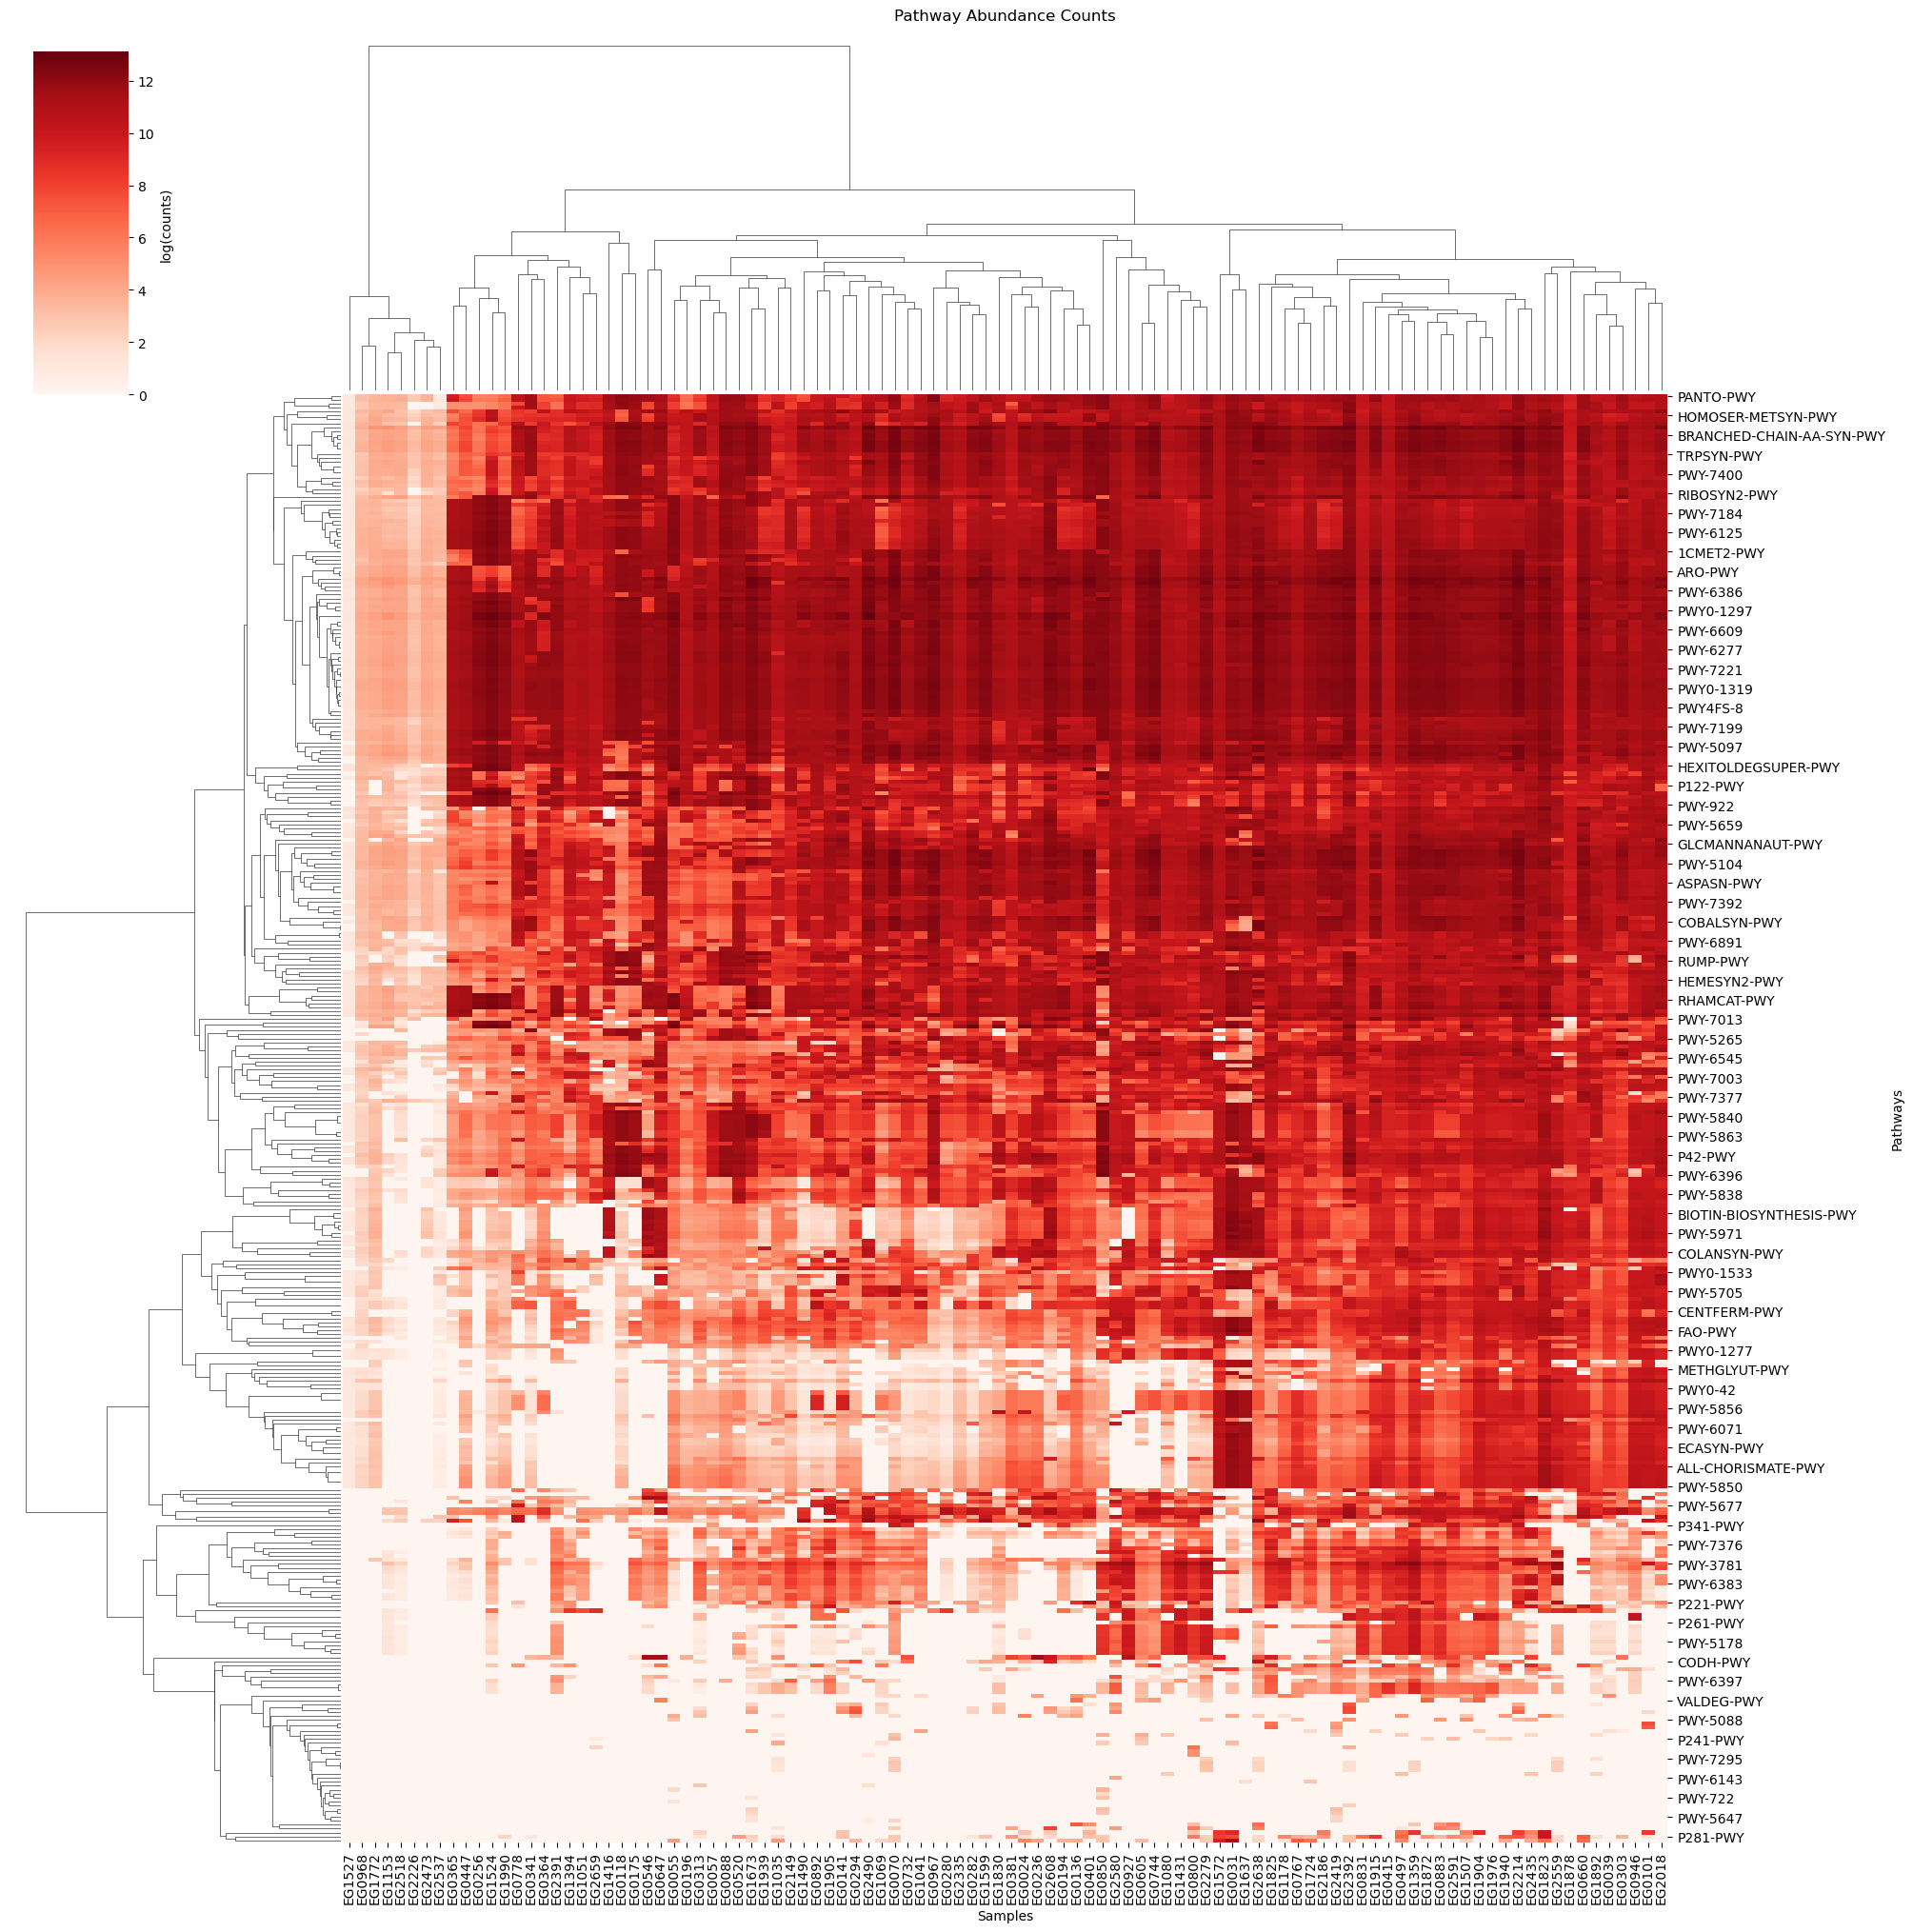

In [51]:
# visualize the data using a clustermap
pathabun_cm = sns.clustermap(pathabun_log.T, cmap="Reds", cbar_kws={'label': 'log(counts)'}, figsize=(20, 20), xticklabels=pathabun_log.index)
pathabun_cm.ax_col_dendrogram.set_title("Pathway Abundance Counts")
pathabun_cm.ax_heatmap.set_xlabel("Samples")
pathabun_cm.ax_heatmap.set_ylabel("Pathways")
pathabun_cm.savefig(vis_dir / "pathway_abundance_clustermap.png")


### 3.5 Exploring function profile clusters

We wish to gain new insights from the functional profiles and see if we can use
functional profile as predictive biomarkers or predicting recovery days. To this
end, we want to examine if samples with similar functional profiles have similar
microbiome compositions and metadata information.

From the clustermap of functional profiles, we can see that the functional
profiles fromed some conpicuous clusters. We want to see if the taxonomic
composition and metadata information are consistent with the clustering. Ideally,
we wish to see diverse taxonomic composition and metadata information within each
cluster.



The following code blocks tried to find whether there is any similarity in the metadata and taxonomical composition of the samples in one very distinct cluster that was found in all the clustermaps (KEGG, EC, and MetaCyc).

In [5]:
meta = pd.read_csv(f"{data_dir}/metadata.tsv", sep="\t", index_col=0)
meta.reset_index(inplace=True)
samples = ["EG1527", "EG0968", "EG1772", "EG1153", "EG2518", "EG2226", "EG2473", "EG2537"]
meta_sub = meta.loc[meta["sample-id"].isin(samples)]
meta_sub

sample-id Patient_ID Stool_Consistency Patient_Sex  Sample_Day  \
2     EG2537       P042            liquid           F           0   
3     EG2518       P043            liquid           M           0   
5     EG2473       P055       semi-formed           M          20   
13    EG2226       P074            liquid           F          23   
33    EG1772       P070            liquid           F          16   
39    EG1527       P003       semi-formed           M          22   
49    EG1153       P016            formed           F          22   
56    EG0968       P047            liquid           M           0   

    Recovery_Day  Cohort_Number  
2           17.0              1  
3           17.0              1  
5           22.0              2  
13          21.0              2  
33          19.0              2  
39          23.0              2  
49          24.0              2  
56          59.0              1

The metadata seems to have no consistent pattern in the cluster.

In [6]:
# look at taxa
taxa = q2.Artifact.load(f"{data_dir}/taxonomy.qza").view(pd.DataFrame)
taxa.head()

Taxon  \
Feature ID                                                                            
65c81b7f020fa6530e5995cfadbed4b8  d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...   
3b5167fc05d221e402cb1748506b8442  d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...   
8b03f72e05e140685a739928d4dd2619  d__Bacteria;p__Firmicutes;c__Clostridia;o__Lac...   
dc5e130892eb358854eb477a790f8af9  d__Bacteria;p__Actinobacteriota;c__Actinobacte...   
9b4ec0ce1b21a5a1172c2f0452d9f241  d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...   

                                          Confidence  
Feature ID                                            
65c81b7f020fa6530e5995cfadbed4b8   0.995352999769101  
3b5167fc05d221e402cb1748506b8442  0.9947820597188002  
8b03f72e05e140685a739928d4dd2619  0.9806855368923134  
dc5e130892eb358854eb477a790f8af9   0.999971217732479  
9b4ec0ce1b21a5a1172c2f0452d9f241  0.9999999999999716

In [7]:
features = q2.Artifact.load(f"{data_dir}/table-filtered.qza")
features = features.view(pd.DataFrame).transpose()
features_sub = features.loc[:, samples]

In [8]:
df = pd.concat([taxa, features_sub], axis=1)

/home/matchy233/study/alien/src/plot.py:299: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/matchy233/study/alien/src/plot.py:299: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


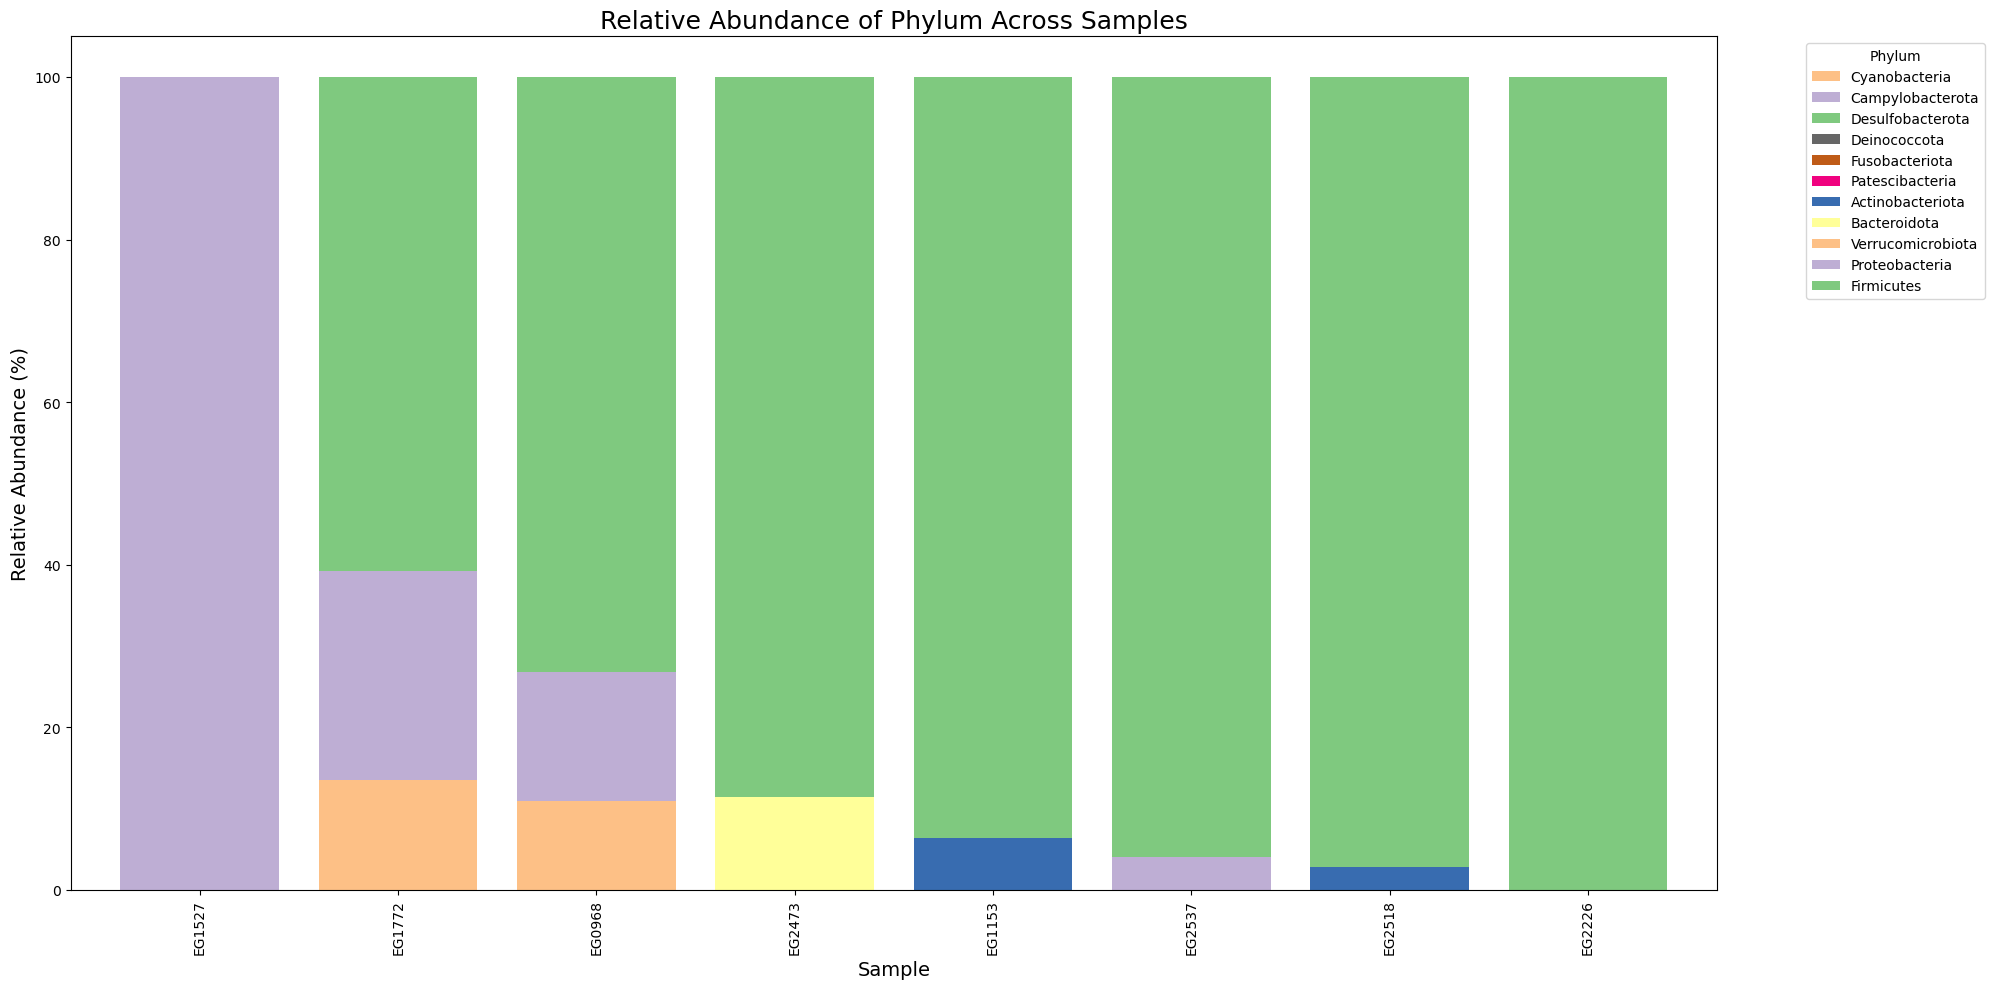

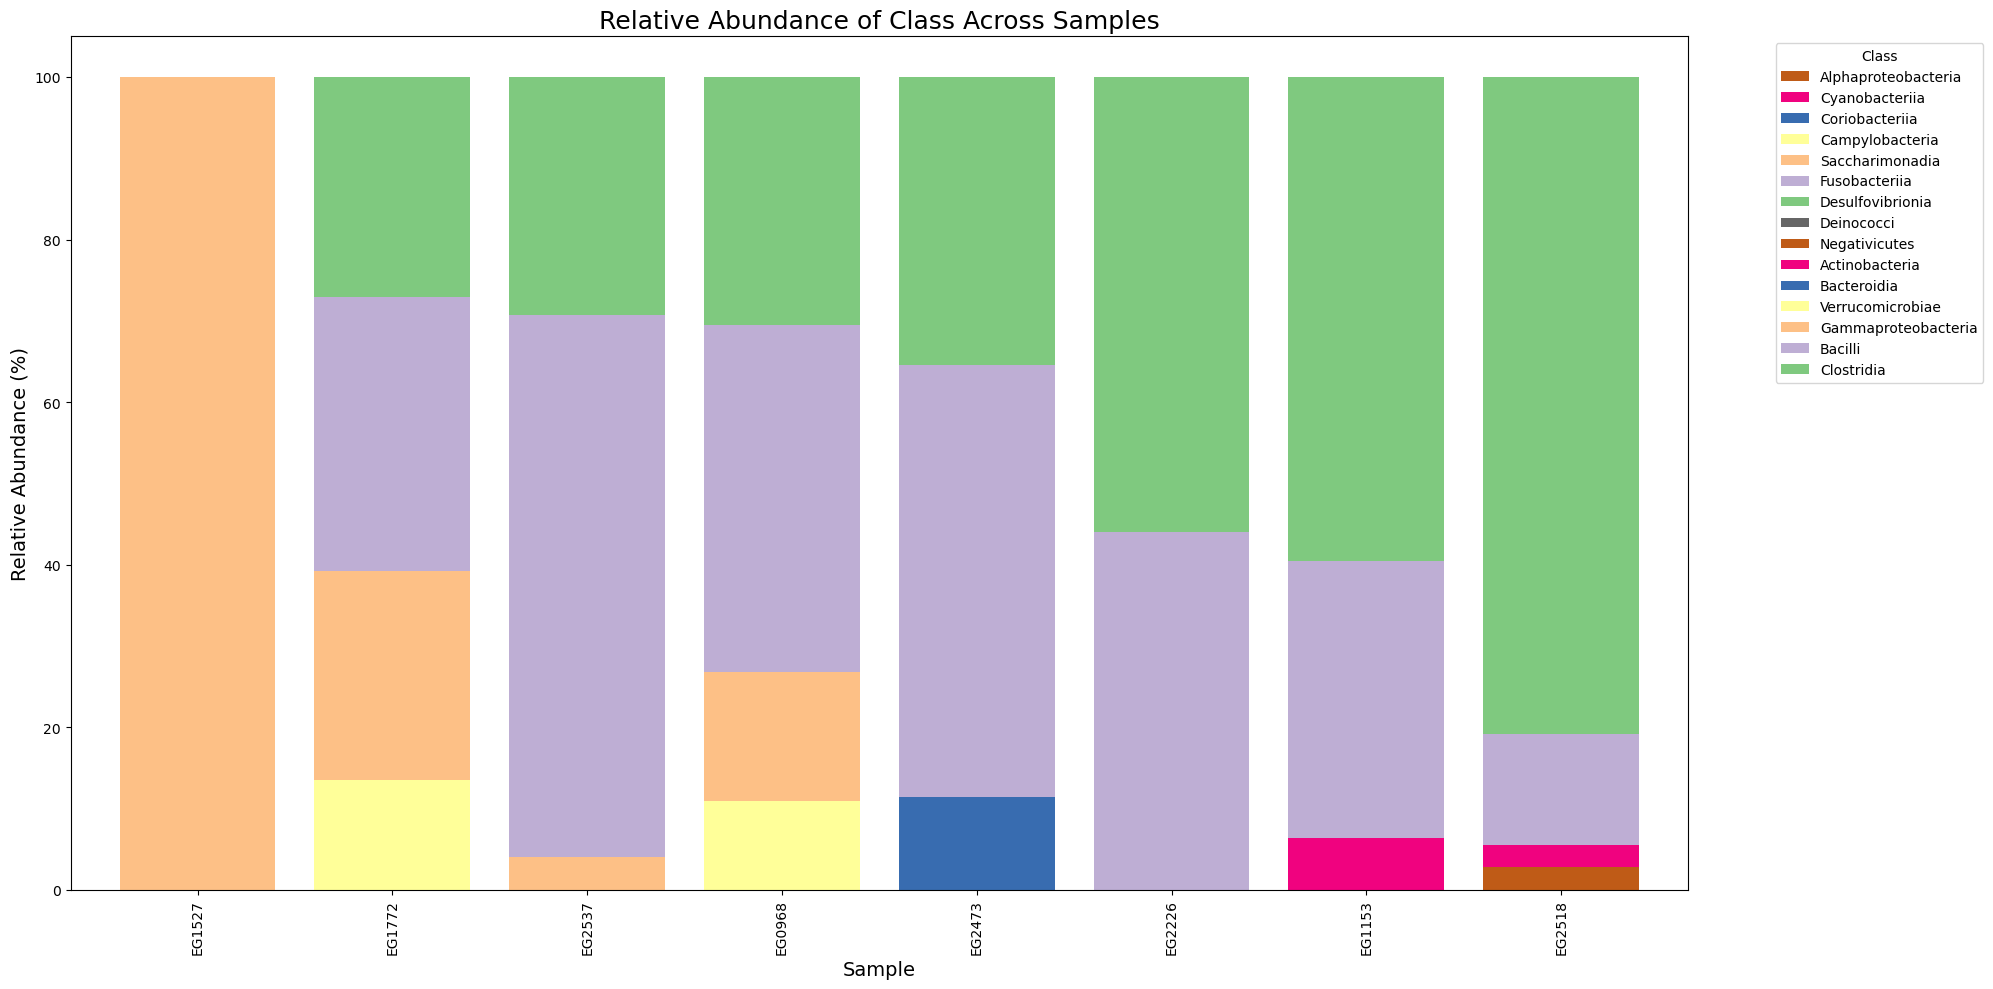

In [9]:
ranks = ["Phylum", "Class"]
plot_taxonomic_abundance(df, ranks)

Similarly, the taxonomic composition also seems to have no consistent pattern in the cluster.

**Conclusion**: Both metadata and taxonomy of the samples in the cluster are not similar. This suggests that the different taxonomical composition and different patient can have similar functional profiles.

## 4. Thoughts and Discussion

Although amplicon-based predictions may be highly correlated with functional profiles based on shotgun metagenomics sequencing data, differential abundance results will likely differ substantially from what would be found based on shotgun metagenomics data. As we requested data from our TA, it is important to compare the results generated from shotgun metagenomics analysis with the prediction from picrust.

## Bibliography

[1] G. M. Douglas et al., “PICRUSt2 for prediction of metagenome functions,” Nature Biotechnology, vol. 38, no. 6, pp. 685–688, Jun. 2020, doi: https://doi.org/10.1038/s41587-020-0548-6.

‌[2] S. Purushothaman, M. Meola, and A. Egli, “Combination of Whole Genome Sequencing and Metagenomics for Microbiological Diagnostics,” International Journal of Molecular Sciences, vol. 23, no. 17, p. 9834, Aug. 2022, doi: https://doi.org/10.3390/ijms23179834.
‌